# 03.  PyTorch Computer Vision Exercises



# Notebook Summary

This notebook explores computer vision concepts using PyTorch and the FashionMNIST dataset.

**Technologies Used:**

*   **PyTorch:** Deep learning framework for building and training neural networks.
*   **torchvision:** Library providing access to datasets, models, and image transformations.
*   **Matplotlib:** For visualizing data and results.
*   **mlxtend:** For plotting the confusion matrix.

**ML Algorithms/Models:**

*   **Convolutional Neural Network (CNN):** A type of neural network well-suited for image data, specifically a TinyVGG-like architecture.

**Main Code Functions:**

*   `training_loop_step`: Performs a single training step for the model.
*   `testing_loop_step`: Evaluates the model on the testing data.
*   `print_train_time`: Utility function to measure training time.
*   `FashionMNIST_model_2`: Defines the CNN model architecture.
*   `make_predictions`: Generates predictions using the trained model.
*   `accuracy_fn`: Calculates the accuracy of the model's predictions.
*   `plot_confusion_matrix`: Visualizes the confusion matrix.

## 1.0 What are 3 areas in industry where computer vision is currently being used?

1.   Modern cars use computer vision to avoid other cars and stay within lane lines.
2.   Manufacturers use computer vision to identify defects in various products.
3.   Security cameras use computer vision to detect potential intruders.
In essence, anything that can be described in a visual sense can be a potential computer vision problem.

### 1.1 Import required libraries and frameworks

In [ ]:
# Import necessary libraries and frameworks
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random

import requests
from pathlib import Path

from tqdm.auto import tqdm
from timeit import default_timer as timer

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

2.6.0+cu124


In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 2.0 Search "what is overfitting in machine learning" and write down a sentence about what you find.

Overfitting means that model is learning the training data well but those patterns aren't generalizing to the testing data.

## 3.0 Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

1. Using a smaller or different model, some models fit certain kinds of data better than others.
2. Using a larger dataset the more data, the more chance a model has to learn generalizable patterns.
3. Early stopping pauses the training phase before the machine learning model learns the noise in the data. However, getting the timing right is important; else the model will still not give accurate results.

## 4.0 Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5.0 Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [ ]:
training_dataset_mnist = datasets.FashionMNIST(root="data",
                                               train=True,
                                               download=True,
                                               transform=ToTensor(),
                                               target_transform=None)

testing_dataset_mnist = datasets.FashionMNIST(root="data",
                                              train=False,
                                              download=True,
                                              transform=ToTensor())

## 6.0 Visualize at least 5 different samples of the MNIST training dataset.

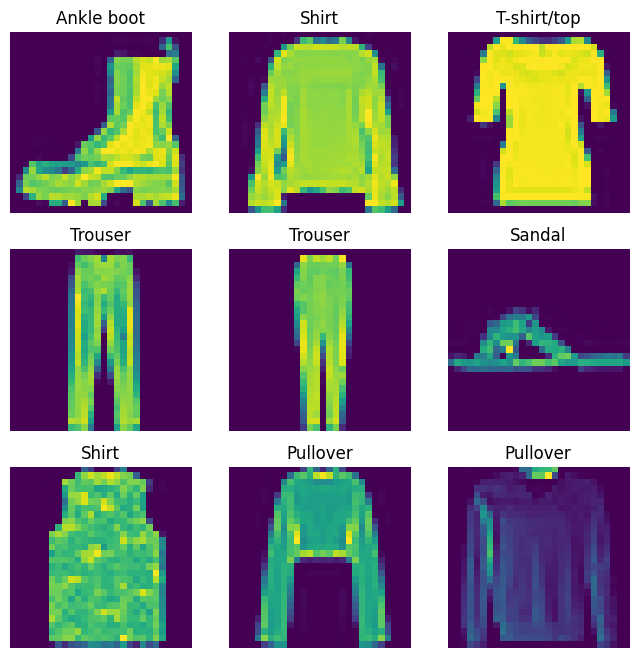

In [ ]:
label_classes = training_dataset_mnist.classes
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
  random_index = torch.randint(0, len(training_dataset_mnist), size=[1]).item()
  img, label_name = training_dataset_mnist[random_index]
  figure.add_subplot(rows, cols, i)
  plt.title(label_classes[label_name])
  plt.axis("off")
  plt.imshow(img.squeeze())
plt.show()

## 7.0 Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [ ]:
BATCH_SIZE = 32
dataloader_training = DataLoader(training_dataset_mnist,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True)
dataloader_testing = DataLoader(testing_dataset_mnist,
                                batch_size=BATCH_SIZE,
                                shuffle=False)

### 7.1. Import helper functions

In [ ]:
from urllib import request
#Download and import helper functions
files = ["helper_functions.py",
         "model_testing_training.py",
         "model_calc_timer.py",
         "pytorch_model_eval.py"]
repos = ["https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py",
         "https://raw.githubusercontent.com/UMB200/pytorch_projects/main/model_testing_training.py",
         "https://raw.githubusercontent.com/UMB200/pytorch_projects/main/model_calc_timer.py",
         "https://raw.githubusercontent.com/UMB200/pytorch_projects/main/pytorch_model_eval.py"]


for i, fd in enumerate(files):
  rl = repos[i]
  if Path(fd).is_file():
    print(f"{fd} already exists, moving on")
  else:
    print(f"Downloading: {fd}")
    try:
      request = requests.get(rl)
      request.raise_for_status()
      with open(fd, "wb") as f:
        f.write(request.content)
      print(f"Successfully downloaded {fd}")
    except requests.exceptions.RequestException as e:
      print(f"Error downloading {fd}: {e}")


helper_functions.py already exists, moving on
model_testing_training.py already exists, moving on
model_calc_timer.py already exists, moving on
pytorch_model_eval.py already exists, moving on


## 8.0 Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [ ]:
def training_loop_step(model: torch.nn.Module,
                        data_loader: torch.utils.data.DataLoader,
                        loss_function: torch.nn.Module,
                        optimizer: torch.optim.Optimizer,
                        accuracy_fn,
                        device: torch.device = device):

  """ Performs a training with model trying to learn on data_loader"""
  ### Training
  training_loss, training_accuracy = 0, 0
  # Set model into training mode
  model.to(device)

  for batch, (X, y) in enumerate(data_loader):
      # Put data on target device
      X, y = X.to(device), y.to(device)
      # 1. Forward pass
      y_prediction = model(X)

      # 2. Calculate loss & accuracy per batch
      loss_value = loss_function(y_prediction, y)
      training_loss += loss_value # accumulate training loss
      training_accuracy += accuracy_fn(y_true = y,
                                        y_pred = y_prediction.argmax(dim=1)) # go from logits -> prediction labels
      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss_value.backward()

      # 5. Optimizer step
      optimizer.step()

  # Calculate the testing loss & accuracy by dividing of testing accuract by the length of test dataloader
  training_loss /= len(data_loader)
  training_accuracy /=len(data_loader)

  print(f"Training loss: {training_loss:.4f} |Training accuracy: {training_accuracy:.2f}%")
### Testing
def testing_loop_step(model: torch.nn.Module,
                      data_loader: torch.utils.data.DataLoader,
                      loss_function: torch.nn.Module,
                      accuracy_fn,
                      device: torch.device = device):
  testing_loss, testing_accuracy = 0, 0
  model.eval()
  model.to(device)
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_prediction = model(X)

      # 2. Calculate loss (accumulatively) & accuracy
      testing_loss += loss_function(test_prediction, y)
      testing_accuracy += accuracy_fn(y_true=y, y_pred=test_prediction.argmax(dim=1))

    # Calculate the test loss & accuracy average by dividing total testing loss and test accuracy by length of dataloader
    testing_loss /= len(data_loader)
    testing_accuracy /=len(data_loader)

    print(f"Testing loss: {testing_loss:.4f} | Testing accuracy: {testing_accuracy:.2f}%")

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
  """ Prints difference between start and end time """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
class FashionMNIST_model_2(torch.nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2))
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )
  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

In [ ]:
model_2_recreated = FashionMNIST_model_2(input_shape=1,
                                         hidden_units=10,
                                         output_shape=len(label_classes)).to(device)
model_2_recreated

FashionMNIST_model_2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## 9.0 Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [ ]:
loss_function_cnn = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_2_recreated.parameters(), lr=0.1)

In [ ]:
from helper_functions import accuracy_fn

In [ ]:
training_time_start = timer()
epoch_qty = 3
for epoch in tqdm(range(epoch_qty)):
  print(f"Epoch: {epoch}\n-------")
  training_loop_step(data_loader=dataloader_training,
                     model=model_2_recreated,
                     loss_function=loss_function_cnn,
                     accuracy_fn=accuracy_fn,
                     optimizer=optimizer,
                     device=device)
  testing_loop_step(model=model_2_recreated,
                    data_loader=dataloader_training,
                    accuracy_fn=accuracy_fn,
                    loss_function=loss_function_cnn,
                    device=device)

training_time_end = timer()

total_training_time = print_train_time(training_time_start,
                                       training_time_end, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Training loss: 0.5996 |Training accuracy: 78.26%
Testing loss: 0.3985 | Testing accuracy: 85.14%
Epoch: 1
-------
Training loss: 0.3633 |Training accuracy: 86.80%
Testing loss: 0.3167 | Testing accuracy: 88.53%
Epoch: 2
-------
Training loss: 0.3242 |Training accuracy: 88.30%
Testing loss: 0.2952 | Testing accuracy: 89.56%
Train time on cpu: 231.596 seconds


## 10.0 Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs_list = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample_data = torch.unsqueeze(sample, dim=0).to(device)
      prediction_logit = model(sample_data).squeeze()
      pred_probability = torch.softmax(prediction_logit, dim=0)
      pred_probs_list.append(pred_probability.cpu())
  return torch.stack(pred_probs_list)

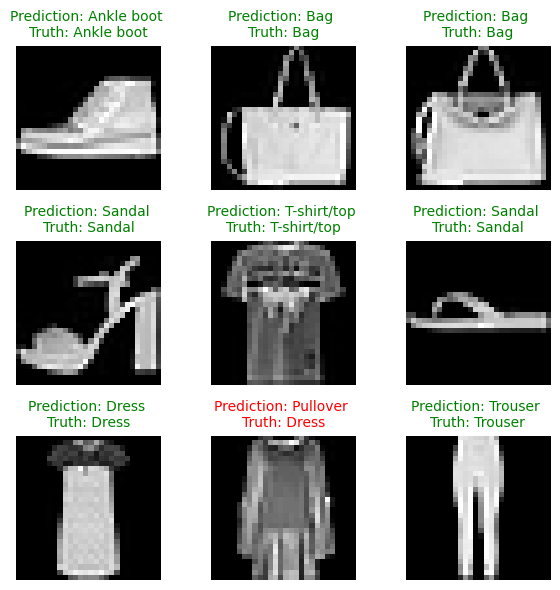

In [ ]:
plt.figure(figsize=(6, 6))
test_images = []
test_labels = []
num_of_rows = 3
num_of_cols = 3

for img, lbl in random.sample(list(testing_dataset_mnist), k=num_of_rows * num_of_cols):
  test_images.append(img)
  test_labels.append(lbl)

prediction_probabilities = make_predictions(model=model_2_recreated,
                                            data=test_images)
prediction_classes = prediction_probabilities.argmax(dim=1)

for i, sample in enumerate(test_images):
  plt.subplot(num_of_rows, num_of_cols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = label_classes[prediction_classes[i]]
  true_label = label_classes[test_labels[i]]
  plt.title(f"Prediction: {pred_label} \nTruth: {true_label}")
  plt.axis("off")
  title_text = f"Prediction: {pred_label} \nTruth: {true_label}"
  if pred_label == true_label:
    plt.title(f"Prediction: {pred_label} \nTruth: {true_label}", fontsize=10, color="green")
  else:
    plt.title(f"Prediction: {pred_label} \nTruth: {true_label}", fontsize=10, color="red")
plt.tight_layout()
plt.show()


## 11.0 Plot a confusion matrix comparing your model's predictions to the truth labels.

In [ ]:
y_prediction_list = []
model_2_recreated.eval()
with torch.inference_mode():
  for X, y in tqdm(dataloader_testing, desc="Making predicions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_2_recreated(X)
    y_prediction = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_prediction_list.append(y_prediction.cpu())
y_prediction_tensor = torch.cat(y_prediction_list)

Making predicions:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 978.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.1 MB/s eta 0:00:00
mlxtend version: 0.23.4


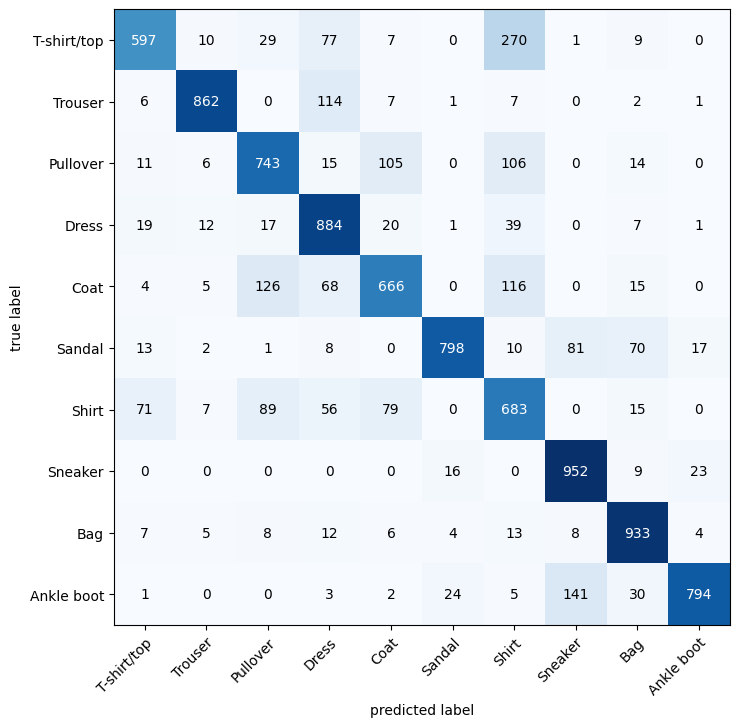

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

conf_matrix_inst = ConfusionMatrix(task="multiclass",
                                   num_classes=len(label_classes))
conf_matrix_tensor = conf_matrix_inst(preds=y_prediction_tensor,
                                      target=testing_dataset_mnist.targets)

fig, ax = plot_confusion_matrix(conf_mat=conf_matrix_tensor.numpy(),
                      figsize=(8, 8),
                      class_names=label_classes)

## 12.0 Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [ ]:
random_tensor = torch.rand(size=(1, 3, 64, 64))
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=3,
                       kernel_size=1,
                       stride=1,
                       padding=1)
conv_layer(random_tensor)

tensor([[[[ 0.1404,  0.1404,  0.1404,  ...,  0.1404,  0.1404,  0.1404],
          [ 0.1404,  0.6561,  0.7106,  ...,  0.7982,  0.6387,  0.1404],
          [ 0.1404,  0.9253,  0.8421,  ...,  0.7777,  0.6849,  0.1404],
          ...,
          [ 0.1404,  0.9698,  0.8599,  ...,  0.7771,  0.7544,  0.1404],
          [ 0.1404,  0.2781,  0.6294,  ...,  0.6983,  0.4821,  0.1404],
          [ 0.1404,  0.1404,  0.1404,  ...,  0.1404,  0.1404,  0.1404]],

         [[ 0.1412,  0.1412,  0.1412,  ...,  0.1412,  0.1412,  0.1412],
          [ 0.1412,  0.4024,  0.4198,  ...,  0.3830,  0.2379,  0.1412],
          [ 0.1412,  0.4165,  0.5931,  ...,  0.4563,  0.2442,  0.1412],
          ...,
          [ 0.1412,  0.4856,  0.4842,  ...,  0.3255,  0.4206,  0.1412],
          [ 0.1412,  0.1925,  0.3930,  ...,  0.5174,  0.2923,  0.1412],
          [ 0.1412,  0.1412,  0.1412,  ...,  0.1412,  0.1412,  0.1412]],

         [[-0.0933, -0.0933, -0.0933,  ..., -0.0933, -0.0933, -0.0933],
          [-0.0933,  0.0321,  

## 13.0 Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

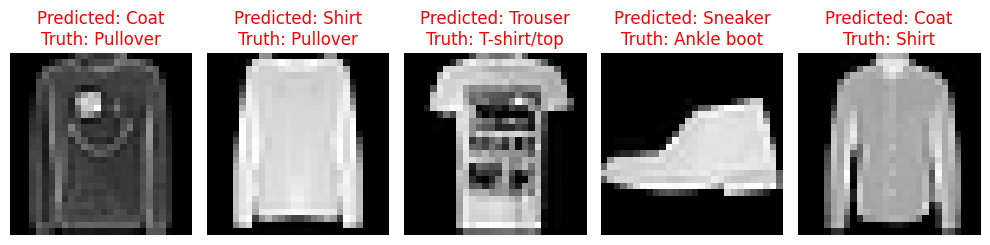

In [ ]:
# Identified wrong predictions and extracted 5 examples when model_02 was wrong
wrong_predictions = torch.where(y_prediction_tensor != testing_dataset_mnist.targets)[0]

# Select 5 random wrong prediction indices
random_wrong_predictions = random.sample(wrong_predictions.tolist(), k=min(5, len(wrong_predictions)))

# Plot 5 wrong predictions
plt.figure(figsize=(10, 10))
for i, wrong_index in enumerate(random_wrong_predictions):
    plt.subplot(1, 5, i + 1)
    image, true_label = testing_dataset_mnist[wrong_index]
    predicted_label = y_prediction_tensor[wrong_index]

    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Predicted: {label_classes[predicted_label]}\nTruth: {label_classes[true_label]}", color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()